In [1]:
import cv2
import numpy as np
from math import log10,sqrt
import skimage
from skimage import color,filters,viewer
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Viewer requires Qt
  """


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Otsu

In [3]:
def PSNR(old,new):
  mse = np.mean((old-new)**2)
  if(mse == 0):
    return 100
  max_pixel = 255.0
  psnr = 20*log10(max_pixel/sqrt(mse))
  return psnr


In [4]:
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data_Public/Diseased_Public_Gaussian/gaussian_0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')
blur = color.rgb2gray(img)
t = filters.threshold_otsu(blur)
mask = blur < t
out = np.zeros_like(img)
out[mask] = img[mask]
print(PSNR(img,out))
cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/public_otsu_unsharp.png',out)
cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/public.png',img)


30.398094988880136


True

In [5]:
path = '/content/drive/MyDrive/Image_Processing_Plants/dataset'

folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))

# WaterShed

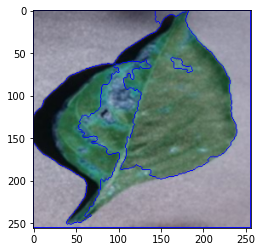

In [6]:
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data_Public/Diseased_Public_Gaussian/gaussian_0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')
img_org = img
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [0,0,255]
plt.imshow(img)
plt.show()

In [7]:
PSNR(img_org,img)

100

# K-Means

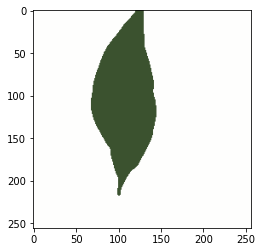

In [8]:
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data/Bacterial-Leaf-Spot-Gaussian/gaussian_bacterial leaf spot (2)bg(stdres).png')
image1 = cv2.GaussianBlur(img,(5,5),0)
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
# flatten the labels array
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()


In [9]:
# disable only the cluster number 2 (turn the pixel into black)
masked_image = np.copy(image)
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))
print(masked_image.shape)
# color (i.e cluster) to disable
cluster = 2
#masked_image[labels == 3] = [0, 0, 0]
#masked_image[labels == 1] = [0, 0, 0]
masked_image[labels == 0] = [0, 0, 0]
# convert back to original shape
masked_image = masked_image.reshape(image.shape)
masked_image1 = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
# show the image
#plt.imshow(masked_image)
#plt.show()


(65536, 3)


In [10]:
labels.shape
segmented_image1  = centers[labels.flatten()]
segmented_image1.shape

centers[labels]

array([[254, 254, 253],
       [254, 254, 253],
       [254, 254, 253],
       ...,
       [254, 254, 253],
       [254, 254, 253],
       [254, 254, 253]], dtype=uint8)

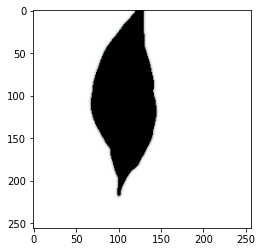

In [11]:
plt.imshow(masked_image1)

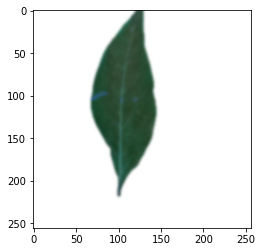

In [12]:
plt.imshow(image1)
plt.show()

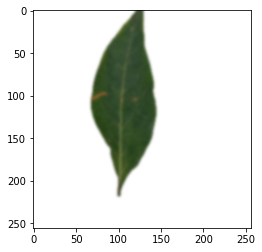

In [13]:
plt.imshow(image)
plt.show()

In [14]:
print(PSNR(image1,masked_image1))
print(PSNR(image,masked_image))


35.42054298023486
35.42054298023486


# Segmentation Functions

In [15]:
def otsu(img):
  blur = color.rgb2gray(img)
  t = filters.threshold_otsu(blur)
  mask = blur < t
  out = np.zeros_like(img)
  out[mask] = img[mask]
  return out

In [16]:
def kmeans(img):
  image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixel_values = image.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  k = 2
  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape(image.shape)
  masked_image = np.copy(image)
  masked_image = masked_image.reshape((-1, 3))
  cluster = 1
  masked_image[labels == cluster] = [0, 0, 0]
  masked_image = masked_image.reshape(image.shape)
  masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
  return masked_image

# Public Dataset

In [17]:
path = '/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data_Public'

folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))

In [18]:
psnr_head_gaussian = ['psnr_gaussian_otsu','psnr_gaussian_kmeans']
ssim_head_gaussian = ['ssim_gaussian_otsu','ssim_gaussian_kmeans']
mse_head_gaussian = ['mse_gaussian_otsu','mse_gaussian_kmeans']

df_Gau_HL_psnr = pd.DataFrame(columns=psnr_head_gaussian)
df_Gau_HL_ssim = pd.DataFrame(columns=ssim_head_gaussian)
df_Gau_HL_mse = pd.DataFrame(columns=mse_head_gaussian)

df_Gau_D_psnr = pd.DataFrame(columns=psnr_head_gaussian)
df_Gau_D_ssim = pd.DataFrame(columns=ssim_head_gaussian)
df_Gau_D_mse = pd.DataFrame(columns=mse_head_gaussian)

psnr_head_unsharp = ['psnr_unsharp_otsu','psnr_unsharp_kmeans']
ssim_head_unsharp = ['ssim_unsharp_otsu','ssim_unsharp_kmeans']
mse_head_unsharp = ['mse_unsharp_otsu','mse_unsharp_kmeans']

df_US_HL_psnr = pd.DataFrame(columns=psnr_head_unsharp)
df_US_HL_ssim = pd.DataFrame(columns=ssim_head_unsharp)
df_US_HL_mse = pd.DataFrame(columns=mse_head_unsharp)

df_US_D_psnr = pd.DataFrame(columns=psnr_head_unsharp)
df_US_D_ssim = pd.DataFrame(columns=ssim_head_unsharp)
df_US_D_mse = pd.DataFrame(columns=mse_head_unsharp)

In [ ]:
for dir in folders:
  for _,_,files in os.walk(dir):
    for f in files:
# Gaussian Diseases data set      
      if("B.Spot" in f and "gaussian" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_gaussian_otsu = PSNR(image,out1)
        ssim_gaussian_otsu = ssim(image,out1,multichannel=True)
        mse_gaussian_otsu = mse(image,out1)

        psnr_gaussian_kmeans = PSNR(image,out)
        ssim_gaussian_kmeans = ssim(image,out,multichannel=True)
        mse_gaussian_kmeans = mse(image,out)

        df_Gau_D_psnr = df_Gau_D_psnr.append({'psnr_gaussian_otsu':psnr_gaussian_otsu,'psnr_gaussian_kmeans':psnr_gaussian_kmeans},ignore_index=True)
        df_Gau_D_ssim = df_Gau_D_ssim.append({'ssim_gaussian_otsu':ssim_gaussian_otsu,'ssim_gaussian_kmeans':ssim_gaussian_kmeans},ignore_index=True)
        df_Gau_D_mse = df_Gau_D_mse.append({'mse_gaussian_otsu':mse_gaussian_otsu,'mse_gaussian_kmeans':mse_gaussian_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Otsu_Gaussian_Diseased/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Kmeans_Gaussian_Diseased/kmeans_'+f,out)
        print("1",end="")
# unsharp Diseases data set      
      elif("B.Spot" in f and "unsharp" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_unsharp_otsu = PSNR(image,out1)
        ssim_unsharp_otsu = ssim(image,out1,multichannel=True)
        mse_unsharp_otsu = mse(image,out1)

        psnr_unsharp_kmeans = PSNR(image,out)
        ssim_unsharp_kmeans = ssim(image,out,multichannel=True)
        mse_unsharp_kmeans = mse(image,out)

        df_US_D_psnr = df_US_D_psnr.append({'psnr_unsharp_otsu':psnr_unsharp_otsu,'psnr_unsharp_kmeans':psnr_unsharp_kmeans},ignore_index=True)
        df_US_D_ssim = df_US_D_ssim.append({'ssim_unsharp_otsu':ssim_unsharp_otsu,'ssim_unsharp_kmeans':ssim_unsharp_kmeans},ignore_index=True)
        df_US_D_mse = df_US_D_mse.append({'mse_unsharp_otsu':mse_unsharp_otsu,'mse_unsharp_kmeans':mse_unsharp_kmeans},ignore_index=True)
        
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Otsu_Unsharp_Diseased/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Kmeans_Unsharp_Diseased/kmeans_'+f,out)
        print("2",end="")

# Gaussian Healthy data set      
      elif("HL" in f and "gaussian" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_gaussian_otsu = PSNR(image,out1)
        ssim_gaussian_otsu = ssim(image,out1,multichannel=True)
        mse_gaussian_otsu = mse(image,out1)

        psnr_gaussian_kmeans = PSNR(image,out)
        ssim_gaussian_kmeans = ssim(image,out,multichannel=True)
        mse_gaussian_kmeans = mse(image,out)

        df_Gau_HL_psnr = df_Gau_HL_psnr.append({'psnr_gaussian_otsu':psnr_gaussian_otsu,'psnr_gaussian_kmeans':psnr_gaussian_kmeans},ignore_index=True)
        df_Gau_HL_ssim = df_Gau_HL_ssim.append({'ssim_gaussian_otsu':ssim_gaussian_otsu,'ssim_gaussian_kmeans':ssim_gaussian_kmeans},ignore_index=True)
        df_Gau_HL_mse = df_Gau_HL_mse.append({'mse_gaussian_otsu':mse_gaussian_otsu,'mse_gaussian_kmeans':mse_gaussian_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Otsu_Gaussian_Healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Kmeans_Gaussian_Healthy/kmeans_'+f,out)
        print("3",end="")

# unsharp Healthy data set      
      elif("HL" in f and "unsharp" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_unsharp_otsu = PSNR(image,out1)
        ssim_unsharp_otsu = ssim(image,out1,multichannel=True)
        mse_unsharp_otsu = mse(image,out1)

        psnr_unsharp_kmeans = PSNR(image,out)
        ssim_unsharp_kmeans = ssim(image,out,multichannel=True)
        mse_unsharp_kmeans = mse(image,out)

        df_US_HL_psnr = df_US_HL_psnr.append({'psnr_unsharp_otsu':psnr_unsharp_otsu,'psnr_unsharp_kmeans':psnr_unsharp_kmeans},ignore_index=True)
        df_US_HL_ssim = df_US_HL_ssim.append({'ssim_unsharp_otsu':ssim_unsharp_otsu,'ssim_unsharp_kmeans':ssim_unsharp_kmeans},ignore_index=True)
        df_US_HL_mse = df_US_HL_mse.append({'mse_unsharp_otsu':mse_unsharp_otsu,'mse_unsharp_kmeans':mse_unsharp_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Otsu_Unsharp_Healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/Kmeans_Unsharp_Healthy/kmeans_'+f,out)
        print("4",end="")

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111444

# Image Quality Metrics on Public Dataset


In [ ]:
df_Gau_HL_psnr.describe() 

,psnr_gaussian_otsu,psnr_gaussian_kmeans
count,1476.000000,1476.000000
mean,30.433361,30.912073
std,0.986378,0.857504
min,28.204951,28.823220
25%,29.738104,30.320547
50%,30.308738,30.793976
75%,30.955127,31.414707
max,36.067844,36.274086


In [ ]:
df_Gau_HL_ssim.describe()

,ssim_gaussian_otsu,ssim_gaussian_kmeans
count,1476.000000,1476.000000
mean,0.285185,0.426066
std,0.148439,0.122966
min,-0.001894,0.059690
25%,0.156261,0.358818
50%,0.283726,0.439202
75%,0.390335,0.505657
max,0.782395,0.841616


In [ ]:
df_Gau_HL_mse.describe()

,mse_gaussian_otsu,mse_gaussian_kmeans
count,1476.000000,1476.000000
mean,14717.610610,8981.136312
std,3939.053096,5798.681464
min,5035.236618,328.494293
25%,11812.973999,3951.183987
50%,14349.401845,7528.218819
75%,17134.909423,13615.371265
max,34104.871857,26802.658086


In [ ]:
df_Gau_D_psnr.describe()

,psnr_gaussian_otsu,psnr_gaussian_kmeans
count,997.000000,997.000000
mean,29.966976,30.939274
std,0.732255,1.010549
min,27.796293,28.083517
25%,29.507573,30.299573
50%,30.006909,30.769195
75%,30.410888,31.407874
max,34.413937,36.960047


In [ ]:
df_Gau_D_ssim.describe()

,ssim_gaussian_otsu,ssim_gaussian_kmeans
count,997.000000,997.000000
mean,0.209739,0.419407
std,0.101985,0.168021
min,-0.001120,0.035637
25%,0.131931,0.285415
50%,0.204206,0.434622
75%,0.277138,0.546777
max,0.684082,0.886526


In [ ]:
df_Gau_D_mse.describe()

,mse_gaussian_otsu,mse_gaussian_kmeans
count,997.000000,997.000000
mean,13998.590995,7647.261572
std,2528.434702,5738.017075
min,6055.829081,171.687851
25%,12469.922562,1867.011495
50%,13726.980850,6184.898514
75%,15187.713862,12973.659424
max,32073.390076,24566.381017


In [ ]:
df_US_HL_psnr.describe()

,psnr_unsharp_otsu,psnr_unsharp_kmeans
count,1476.000000,1476.000000
mean,30.296861,30.973816
std,0.820217,0.860820
min,28.404356,28.946706
25%,29.746195,30.348450
50%,30.173341,30.895127
75%,30.704139,31.533301
max,35.398196,35.729331


In [ ]:
df_US_HL_ssim.describe()

,ssim_unsharp_otsu,ssim_unsharp_kmeans
count,1476.000000,1476.000000
mean,0.094108,0.361149
std,0.120638,0.209307
min,-0.148235,-0.098149
25%,0.009955,0.169248
50%,0.070461,0.392066
75%,0.157672,0.539824
max,0.643101,0.805070


In [ ]:
df_US_HL_mse.describe()

,mse_unsharp_otsu,mse_unsharp_kmeans
count,1476.000000,1476.000000
mean,15665.804488,9091.104958
std,4103.338543,6558.965061
min,5699.987768,510.242849
25%,12681.478175,3177.423630
50%,15423.455866,6583.108943
75%,18179.420870,14702.581505
max,36000.193797,28811.358632


In [ ]:
df_US_D_psnr.describe()

,psnr_unsharp_otsu,psnr_unsharp_kmeans
count,997.000000,997.000000
mean,29.961701,31.038561
std,0.624896,1.100110
min,27.610842,28.237831
25%,29.631241,30.271339
50%,29.992702,30.825063
75%,30.348909,31.687054
max,34.012159,37.356591


In [ ]:
df_US_D_ssim.describe()

,ssim_unsharp_otsu,ssim_unsharp_kmeans
count,997.000000,997.000000
mean,0.088391,0.381999
std,0.082722,0.252905
min,-0.158333,-0.121850
25%,0.031574,0.143122
50%,0.084634,0.433082
75%,0.135749,0.621091
max,0.459500,0.911117


In [ ]:
df_US_D_mse.describe()

,mse_unsharp_otsu,mse_unsharp_kmeans
count,997.000000,997.000000
mean,14835.098847,8122.816099
std,2490.224514,6445.716896
min,6799.629649,156.834152
25%,13343.012594,1524.704992
50%,14556.102905,8429.094935
75%,15916.140889,14047.255163
max,32770.137110,28876.138631


In [ ]:
df_Gau_HL_psnr.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/PSNR_Healthy_Gaussian.csv',index=False) 
df_Gau_HL_ssim.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/SSIM_Healthy_Gaussian.csv',index=False)
df_Gau_HL_mse.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/MSE_Healthy_Gaussian.csv',index=False)

df_Gau_D_psnr.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/PSNR_Diseased_Gaussian.csv',index=False)
df_Gau_D_ssim.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/SSIM_Diseased_Gaussian.csv',index=False)
df_Gau_D_mse.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/MSE_Diseased_Gaussian.csv',index=False)

df_US_HL_psnr.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/PSNR_Healthy_Unsharp.csv',index=False)
df_US_HL_ssim.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/SSIM_Healthy_Unsharp.csv',index=False)
df_US_HL_mse.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/MSE_Healthy_Unsharp.csv',index=False)

df_US_D_psnr.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/PSNR_Diseased_Unsharp.csv',index=False)
df_US_D_ssim.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/SSIM_Diseased_Unsharp.csv',index=False)
df_US_D_mse.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Public_Dataset/MSE_Diseased_Unsharp.csv',index=False)

# Private Dataset


In [ ]:
path = '/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data'

folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))

In [ ]:
column_names =['psnr_otsu','ssim_otsu','mse_otsu','psnr_kmeans','ssim_kmeans','mse_kmeans']
df_Gau_curl = pd.DataFrame(columns=column_names)
df_Gau_pests = pd.DataFrame(columns=column_names)
df_Gau_bacterial = pd.DataFrame(columns=column_names)
df_Gau_fusarium = pd.DataFrame(columns=column_names)
df_Gau_healthy = pd.DataFrame(columns=column_names)

df_us_curl = pd.DataFrame(columns=column_names)
df_us_pests = pd.DataFrame(columns=column_names)
df_us_bacterial = pd.DataFrame(columns=column_names)
df_us_fusarium = pd.DataFrame(columns=column_names)
df_us_healthy = pd.DataFrame(columns=column_names)


In [ ]:
for dir in folders:
  for _,_,files in os.walk(dir):
    for f in files:

# Gaussian Curl Dataset
      if(f.startswith("gaussian_curl_")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_curl = df_Gau_curl.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Gaussian_curl/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Gaussian_curl/kmeans_'+f,out)

# Gaussian pests dataset        
      elif(f.startswith("gaussian_pests_")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_pests = df_Gau_pests.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Gaussian_pests/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Gaussian_pests/kmeans_'+f,out)

# Gaussian Healthy 
      elif(f.startswith("gaussian_healthy")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_healthy = df_Gau_healthy.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Gaussian_healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Gaussian_healthy/kmeans_'+f,out)

# Gaussian Fusarium dataset        
      elif(f.startswith("gaussian_fusarium")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_fusarium = df_Gau_fusarium.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Gaussian_fusarium/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Gaussian_fusarium/kmeans_'+f,out)

# Gaussian Bacterial
      elif(f.startswith("gaussian_bacterial")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_bacterial = df_Gau_bacterial.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Gaussian_bacterial/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Gaussian_bacterial/kmeans_'+f,out)

# Unsharp Curl Dataset
      elif(f.startswith("unsharp_curl_")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_us_curl = df_us_curl.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Unsharp_curl/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Unsharp_curl/kmeans_'+f,out)

# Unsharp pests dataset        
      elif(f.startswith("unsharp_pests_")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_us_pests = df_us_pests.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Unsharp_pests/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Unsharp_pests/kmeans_'+f,out)


# Unsharp Healthy 
      elif(f.startswith("unsharp_healthy")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_us_healthy = df_us_healthy.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Unsharp_healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Unsharp_healthy/kmeans_'+f,out)

# Unsharp Fusarium dataset        
      elif(f.startswith("unsharp_fusarium")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_us_fusarium = df_us_fusarium.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Unsharp_fusarium/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Unsharp_fusarium/kmeans_'+f,out)

# Unsharp Bacterial
      elif(f.startswith("unsharp_bacterial")):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_us_bacterial = df_us_bacterial.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Otsu_Unsharp_bacterial/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Kmeans_Unsharp_bacterial/kmeans_'+f,out)


In [ ]:
df_Gau_curl.describe() 

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,43.382872,0.146651,52793.475221,39.520107,0.477944,27589.464613
std,0.399644,0.072742,4828.184105,4.149486,0.347109,26148.869185
min,42.191700,0.030673,31299.402206,30.493623,0.030611,135.239899
25%,43.156944,0.099186,50184.040204,35.360947,0.130358,598.154689
50%,43.426624,0.130458,53986.675552,42.584462,0.298538,42206.813675
75%,43.611049,0.182923,56155.457794,43.409174,0.839021,53999.327443
max,45.181465,0.473155,61854.392695,45.170480,0.934743,61855.423731


In [ ]:
df_Gau_pests.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,43.193881,0.149731,52190.263222,38.303502,0.535554,22235.863366
std,0.548736,0.054457,3694.924960,4.236267,0.332867,25573.071121
min,40.942058,0.043168,39119.118607,31.896863,0.043036,332.326294
25%,43.047413,0.113838,50377.413649,34.627122,0.150946,857.671846
50%,43.360653,0.140417,52981.290306,35.896135,0.762692,1592.186592
75%,43.548755,0.173663,54593.971046,43.225745,0.826436,52061.210579
max,44.147359,0.343295,59181.736705,43.753475,0.917067,58893.569514


In [ ]:
df_Gau_bacterial.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,43.570214,0.148121,52460.230463,39.849881,0.450771,29456.270216
std,0.405024,0.069473,4613.158106,4.213891,0.339710,25571.208498
min,42.455685,0.022861,36471.539179,32.639291,0.029321,580.212774
25%,43.388713,0.095879,48974.925948,35.606871,0.131634,1623.628241
50%,43.631817,0.136291,53322.115807,42.837428,0.242475,46076.124054
75%,43.786967,0.197159,55911.936907,43.646344,0.798747,53638.946181
max,44.543366,0.388120,61268.457067,44.533378,0.946895,61250.625448


In [ ]:
df_Gau_fusarium.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,43.261729,0.184823,49909.460460,38.786981,0.494781,24528.759945
std,0.589729,0.093280,6251.520110,4.666471,0.310501,24657.939216
min,41.143309,0.002122,32039.688039,30.516212,0.023376,150.945862
25%,42.922951,0.127063,47046.692179,34.368963,0.172607,1118.508334
50%,43.293831,0.172491,50969.283005,42.321765,0.604376,2010.328064
75%,43.501542,0.227769,53899.289820,43.252942,0.789655,50895.818344
max,45.803552,0.462891,63698.465444,45.421670,0.984086,62079.264445


In [ ]:
df_Gau_healthy.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,43.508309,0.166062,51817.140926,38.932464,0.500463,25168.127729
std,0.311693,0.055804,3748.010595,4.483768,0.326672,25783.188816
min,42.539162,0.056182,38139.258128,31.518139,0.056204,245.828262
25%,43.390946,0.129762,49958.001485,34.509300,0.166269,537.413439
50%,43.574795,0.164549,51878.812922,36.800532,0.668860,985.786967
75%,43.671061,0.197119,54217.358587,43.534001,0.811981,51792.832535
max,44.627938,0.375661,59836.281865,44.631065,0.913184,59835.948222


In [ ]:
df_us_curl.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,48.427009,0.154143,53058.390385,41.242991,0.541509,23393.871170
std,0.596173,0.073107,4797.880674,6.502532,0.345054,26064.592462
min,45.896454,0.032711,31674.997518,30.480620,0.032658,83.507721
25%,48.235797,0.106066,50441.369921,35.469504,0.163365,428.146418
50%,48.479461,0.138191,54212.899587,37.680657,0.758906,965.678151
75%,48.729952,0.188767,56426.940770,48.395814,0.855192,52486.021200
max,50.100982,0.485564,61988.876577,49.982857,0.941811,61989.960505


In [ ]:
df_us_pests.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,48.049913,0.157754,52464.744167,41.727414,0.472257,27930.182138
std,1.097667,0.054421,3690.344392,6.627249,0.338703,26144.359139
min,43.758476,0.056825,39327.628662,32.281422,0.057020,237.461436
25%,47.937018,0.123140,50666.810087,35.108777,0.140317,824.580699
50%,48.380803,0.147647,53248.265795,45.044156,0.291835,43864.302500
75%,48.607864,0.182135,54900.925411,48.361407,0.823063,53526.615824
max,49.573485,0.349519,59328.418427,49.354116,0.927036,59328.426809


In [ ]:
df_us_bacterial.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,48.547122,0.156795,52706.533008,40.507507,0.590358,19968.023112
std,0.477731,0.069528,4598.571743,6.354200,0.327728,24483.015142
min,47.097886,0.029065,36757.277400,31.291713,0.042584,255.866211
25%,48.272789,0.105162,49242.110158,35.312712,0.213359,1025.699121
50%,48.598112,0.146819,53591.318227,37.092684,0.773276,1855.513390
75%,48.848873,0.206589,56070.841788,48.298865,0.855233,49115.108438
max,50.134841,0.398829,61463.377426,50.037473,0.956111,60397.659144


In [ ]:
df_us_fusarium.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,48.168119,0.194063,50131.704834,41.398988,0.500355,25102.763298
std,0.648832,0.093961,6226.866315,6.845679,0.310792,24670.710904
min,45.579237,0.004863,32296.291468,30.547885,0.005229,107.568039
25%,47.870884,0.134977,47263.719607,34.728040,0.189519,984.366572
50%,48.177798,0.181488,51160.018219,44.482037,0.500415,2037.203974
75%,48.576965,0.240803,54120.552986,48.054009,0.812787,50459.705912
max,50.070251,0.471949,63815.420090,50.035794,0.983888,63813.654037


In [ ]:
df_us_healthy.describe()

,psnr_otsu,ssim_otsu,mse_otsu,psnr_kmeans,ssim_kmeans,mse_kmeans
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,48.555582,0.171978,52106.979595,41.817861,0.490270,26683.763411
std,0.431923,0.055955,3729.699961,6.892150,0.328873,26032.819717
min,47.104334,0.058560,38499.771525,31.460846,0.058560,112.647792
25%,48.299385,0.135503,50225.938853,34.754059,0.173363,412.189176
50%,48.619444,0.170031,52182.879349,47.167256,0.304892,43134.548696
75%,48.835195,0.202623,54517.393161,48.593479,0.821510,51944.033025
max,49.946936,0.381679,60044.961390,49.851414,0.920223,60044.961390


In [ ]:
df_Gau_curl.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Gaussian_curl.csv',index=False)
df_Gau_pests.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Gaussian_pests.csv',index=False)
df_Gau_bacterial.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Gaussian_bacterial.csv',index=False)
df_Gau_fusarium.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Gaussian_fusarium.csv',index=False)
df_Gau_healthy.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Gaussian_healthy.csv',index=False)

df_us_curl.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Unsharp_curl.csv',index=False)
df_us_pests.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Unsharp_pests.csv',index=False)
df_us_bacterial.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Unsharp_bacterial.csv',index=False)
df_us_fusarium.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Unsharp_fusarium.csv',index=False)
df_us_healthy.to_csv('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/Private_Dataset/Unsharp_healthy.csv',index=False)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data/Bacterial-Leaf-Spot-Gaussian/gaussian_bacterial leaf spot (2)bg(stdres).png')
image1 = cv2.GaussianBlur(img,(5,5),0)
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
# flatten the labels array
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
len(segmented_image)

65536

In [ ]:
for i in centers:
  if i[0] in range(230,256) and i[1] in range(230,256) and i[2] in range(230,256):
    temp = i
for i in range(len(segmented_image)):
  if not ((segmented_image[i]-temp).any()):
    segmented_image[i] = [0,0,0]
    labels[i] = -1

np.count_nonzero(labels == -1)
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)

array([254, 254, 253], dtype=uint8)

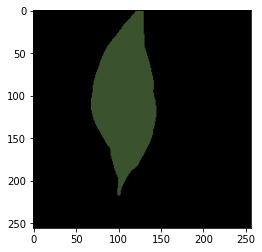

In [ ]:
for i in range(len(segmented_image)):
  if not ((segmented_image[i]-temp).any()):
    segmented_image[i] = [0,0,0]
    labels[i] = -1

np.count_nonzero(labels == -1)
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)

In [ ]:
# disable only the cluster number 2 (turn the pixel into black)
masked_image = np.copy(image)
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))

# color (i.e cluster) to disable
cluster = 2
#masked_image[labels == 3] = [0, 0, 0]
#masked_image[labels == 1] = [0, 0, 0]
masked_image[labels == -1] = [0, 0, 0]
# convert back to original shape
masked_image = masked_image.reshape(image.shape)
masked_image1 = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
# show the image
plt.imshow(masked_image)
plt.show()


In [ ]:
def kmeans_updated(img):
  image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixel_values = image.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  k = 3
  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()
  segmented_image = centers[labels.flatten()]

  for i in centers:
    if i[0] in range(230,256) and i[1] in range(230,256) and i[2] in range(230,256):
      temp = i
  for i in range(len(segmented_image)):
    if not ((segmented_image[i]-temp).any()):
      segmented_image[i] = [0,0,0]
      labels[i] = -1

  segmented_image = segmented_image.reshape(image.shape)
  masked_image = np.copy(image)
  masked_image = masked_image.reshape((-1, 3))
  cluster = -1
  masked_image[labels == cluster] = [0, 0, 0]
  masked_image = masked_image.reshape(image.shape)
  masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
  return masked_image

In [ ]:
path = '/content/drive/MyDrive/Image_Processing_Plants/Filtered_Data/Bacterial-Leaf-Spot-Gaussian'

for root,dirs,files in os.walk(path):
  for f in files:
        image = cv2.imread(os.path.join(path,f))
        out1 = otsu(image)
        out = kmeans_updated(image)
        
        psnr_otsu = PSNR(image,out1)
        ssim_otsu = ssim(image,out1,multichannel=True)
        mse_otsu = mse(image,out1)

        psnr_kmeans = PSNR(image,out)
        ssim_kmeans = ssim(image,out,multichannel=True)
        mse_kmeans = mse(image,out)

        df_Gau_curl = df_Gau_curl.append({'psnr_otsu':psnr_otsu,'ssim_otsu':ssim_otsu,'mse_otsu':mse_otsu,
                                          'psnr_kmeans':psnr_kmeans,'ssim_kmeans':ssim_kmeans,'mse_kmeans':mse_kmeans},ignore_index=True)
        cv2.imwrite('/content/drive/MyDrive/Image_Processing_Plants/Segmented_data/sample/kmeans_'+f,out)
